# Create animation

This notebook creates timeseries animations of model predictions

#### First load the change in fields data

In [1]:
import pandas as pd
change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')

In [2]:

#This is the same as defined in notebook 2
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)


    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped


#### Then load the model predictions

In [3]:
V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_augmented/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented/'
V20X_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented_monthlyclake/'


print ('----------V15----------')
V15_predictions,V15_predictions_averaged = load_predictions(V15_model) #averaged = averaged over the year
print ('----------V20----------')
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)
print ('----------V20X----------')
V20X_predictions,V20X_predictions_averaged = load_predictions(V20X_model)

----------V15----------
Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
----------V20----------
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806
----------V20X----------
Mean/Median/Std prediction bias: 0.018071566 0.15356445 3.9607246
Mean/Median/Std prediction error: 2.9511783 2.2535706 2.6416352


#### Now make a single dataframe which holds the non-averaged data, and the category

In [4]:
#Create a timeseries

data_timeseries = {'latitude_ERA':    V20_predictions.latitude_ERA, 
                   'longitude_ERA':   V20_predictions.longitude_ERA,
                   'time':            V20_predictions.time,
                   'V15_error':       V15_predictions.predicion_error,
                   'V20_error':       V20_predictions.predicion_error,
                   'V20X_error':      V20X_predictions.predicion_error}
df_timeseries = pd.DataFrame(data_timeseries)   
df_timeseries['month'] = pd.DatetimeIndex(df_timeseries.time).month
df_timeseries['day'] = pd.DatetimeIndex(df_timeseries.time).date
df_timeseries_categorized = pd.merge(df_timeseries,change_in_fields,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

#### And now we can make an animation of a selected subset of that data

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as mc
import matplotlib.colorbar as cb
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs


import sys
def make_animation(df,condition,col,fname):
    """
    df: input dataframe to plot
    condition: thing to filter the input df on
    y: the quantity you want to plot
    """
    
    df_selected = df.query(condition)
    df_lite = df_selected[['latitude_ERA', 'longitude_ERA', 'month', col]].copy()                         #Selet only a few columns
    ds_map = df_lite.groupby(['latitude_ERA', 'longitude_ERA','month'],as_index=False).mean()  #Group by month

        
    # Data for plotting
    t = np.unique(ds_map.month)
    frames = len(t)
    markersize = 10
    
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])


    cmap = plt.cm.viridis
    norm = mc.Normalize(vmin=1, vmax=5)
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal'
                               )



    titles = ['Jan 2019','Feb 2019','March 2019','Apr 2019','May 2019','Jun 2019',
             'Jul 2019','Aug 2019','Sept 2019','Oct 2019','Nov 2019','Dec 2019']
    
    
    #Nested function
    def update(i):
        # clear the axis each frame
        ax.clear()


        #Get the data
        ti=t[i]
        condition = f"month == {ti}"
        ds = ds_map.query(condition)


        #Get data
        x = ds['latitude_ERA']
        y = ds['longitude_ERA']
        z1 = ds[col]



        # replot things
        sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                        s=markersize,
                        c=cmap(norm(z1)),
                        linewidths=1, 
                        alpha=.7)

        title = titles[i]
        print(title)
        ax.set_title(title)

        #Latitude cutoffs
        ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
        ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


        #Formatting
        cax.tick_params(labelsize=16)
        cax.set_xlabel('K',fontsize=16)

        ax.coastlines()
        ax.set_aspect('auto') #Force projection aspect ratio
        
        
    
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)
    ani.save(f'figs/{fname}.mp4')



    

Jan 2019
Jan 2019
Feb 2019
March 2019
Apr 2019
May 2019
Jun 2019
Jul 2019
Aug 2019
Sept 2019
Oct 2019
Nov 2019
Dec 2019


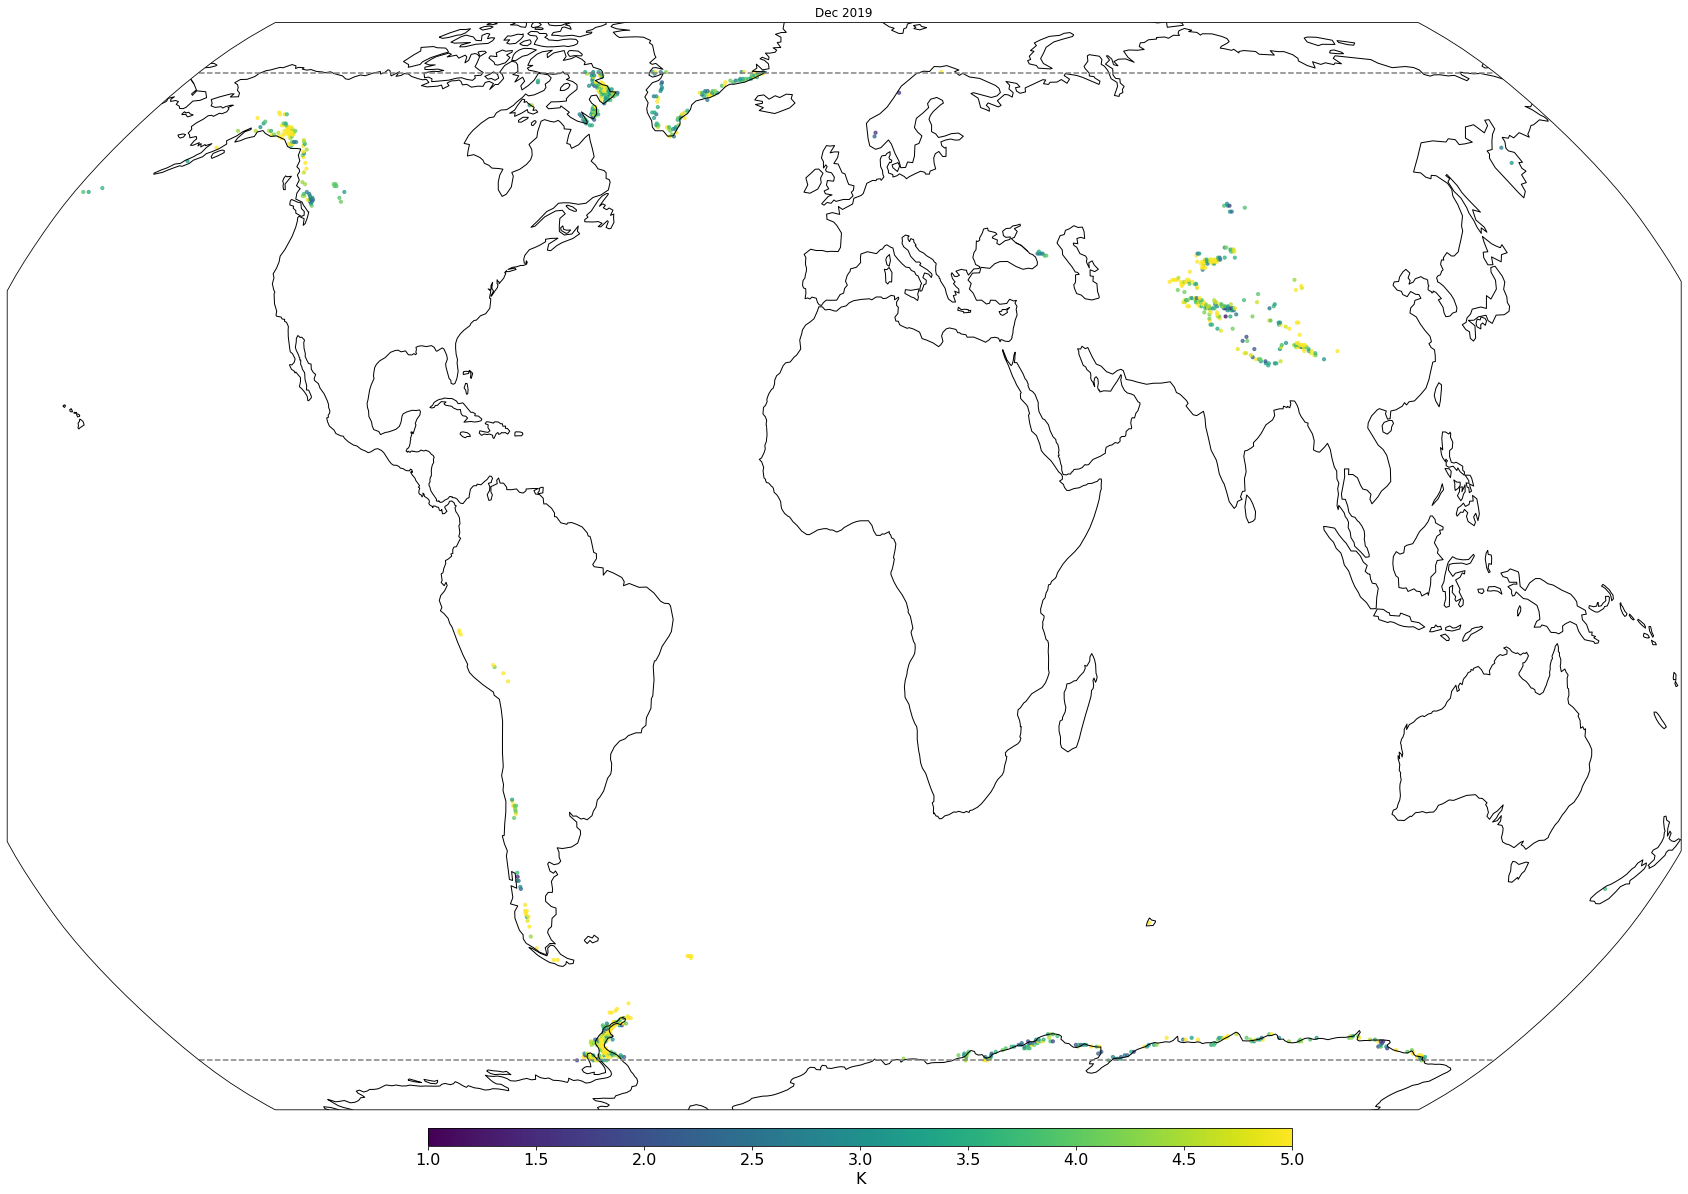

In [22]:
df = df_timeseries_categorized
condition = 'bitstring == "000101"'
y = 'V15_error'
fname = 'animation_000101_V15'

make_animation(df,condition,y,fname)